Para Verificar Performance da GPU Usar o Comando:

watch -n 1 amd-smi

## Modo do Script:

TRAIN: o modelo será treinado e o melhor registrado será salvo.

TEST: o modelo salvo será testado com o dataset de teste

BOTH: o modelo sera treinado, salvo e testado

In [1]:
SCRIPT_MODE = "BOTH"

# Setup do Projeto

In [2]:
import torch

# Setup Agnostic Code for GPU/CPU
if torch.cuda.is_available():
    device = 'cuda'
    print(f"CUDA está disponivel!\nDispositivo configurado para: {device}\nDevice count: {torch.cuda.device_count()}\nNome do dispositivo: {torch.cuda.get_device_name(0)}\nVersao do PyTorch: {torch.__version__}")
else:
    device = 'cpu'
    print(f"CUDA não está disponível.\nDispositivo configurado para: {device}\nVersao do PyTorch: {torch.__version__}")

CUDA está disponivel!
Dispositivo configurado para: cuda
Device count: 2
Nome do dispositivo: AMD Radeon RX 7800 XT
Versao do PyTorch: 2.9.1+rocm7.2.0.git7e1940d4


In [3]:
# Constantes
import os

DATA_PATH = '/home/jose-vitor/Documents/Cityscapes_Dataset'

IM_HEIGHT = 256
IM_WIDTH = 512

BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count() // 2

NUM_CLASSES = 20 # Numero de classes do dataset, incluindo a classe de ignorar (void)

In [4]:
# Bibliotecas e imports
import custom_cityscapes as ccs
import custom_transforms as ctr
import linknet_model as lkm
import train_model as tr
import test_model as ts
from utils import dataset_show

from torchvision import datasets
from torch.utils.data import DataLoader
from torchinfo import summary
from pathlib import Path

# Preparando o Dataset Cityscapes

In [5]:
ds_lables = ccs.CityscapesLables()

# Imprimindo informacoes relevantes
print(f"O dataset possui {len(ds_lables.id_names)} classes treinaveis:")
ds_lables.id_names

O dataset possui 20 classes treinaveis:


{0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic light',
 7: 'traffic sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'bicycle',
 19: 'ignore'}

In [6]:
# Imprimir o dictionário de mapeamento de ids originais para ids de treino
print("\nDicionário de mapeamento de ids originais para ids de treino:")
ds_lables.lable_conversion


Dicionário de mapeamento de ids originais para ids de treino:


{0: 19,
 1: 19,
 2: 19,
 3: 19,
 4: 19,
 5: 19,
 6: 19,
 7: 0,
 8: 1,
 9: 19,
 10: 19,
 11: 2,
 12: 3,
 13: 4,
 14: 19,
 15: 19,
 16: 19,
 17: 5,
 18: 19,
 19: 6,
 20: 7,
 21: 8,
 22: 9,
 23: 10,
 24: 11,
 25: 12,
 26: 13,
 27: 14,
 28: 15,
 29: 19,
 30: 19,
 31: 16,
 32: 17,
 33: 18}

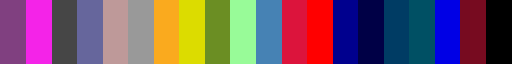

In [7]:
# Criando o colormap para as classes
cmap = ds_lables.get_cmap()
cmap

# Importar o Dataset Cityscapes

Definir Funções de Transform

In [8]:
custom_trans = ctr.Transforms(conv_size=(IM_HEIGHT, IM_WIDTH),
                              lable_conversion=ds_lables.lable_conversion)

Importar Dataset

In [9]:
train_dataset = ccs.AugmentedCityscapes(DATA_PATH,
                             split = 'train',
                             mode='fine',
                             target_type='semantic',
                             transform=custom_trans.train_transform,
                             target_transform=custom_trans.target_transform,
                             data_augmentation=custom_trans.data_augmentation)
val_dataset = datasets.Cityscapes(DATA_PATH,
                           split = 'val',
                           mode='fine',
                           target_type='semantic',
                           transform=custom_trans.val_transform,
                           target_transform=custom_trans.target_transform)
test_dataset = datasets.Cityscapes(DATA_PATH,
                            split = 'test',
                            mode='fine',
                            target_type='semantic',
                            transform=custom_trans.val_transform,
                            target_transform=custom_trans.target_transform)

In [10]:
# Imprimir informacoes importantes dos datasets
img, smnt = train_dataset[0]
print(f"O Dataset de treino possui {len(train_dataset)} amostras.\n"
      f"O Dataset de validação possui {len(val_dataset)} amostras.\n"
      f"O Dataset de teste possui {len(test_dataset)} amostras.\n"
      f"Cada imagem posssui tamanho {img.shape} e tipo {img.dtype}, e cada mascara possui tamanho {smnt.shape} e tipo {smnt.dtype}.\n")

#print(f"Primeira Imagem do dataset de treino:\n{img}\nPrimenra mascara do dataset de treino:\n{smnt}")

O Dataset de treino possui 2975 amostras.
O Dataset de validação possui 500 amostras.
O Dataset de teste possui 1525 amostras.
Cada imagem posssui tamanho torch.Size([3, 256, 512]) e tipo torch.float32, e cada mascara possui tamanho torch.Size([256, 512]) e tipo torch.uint8.



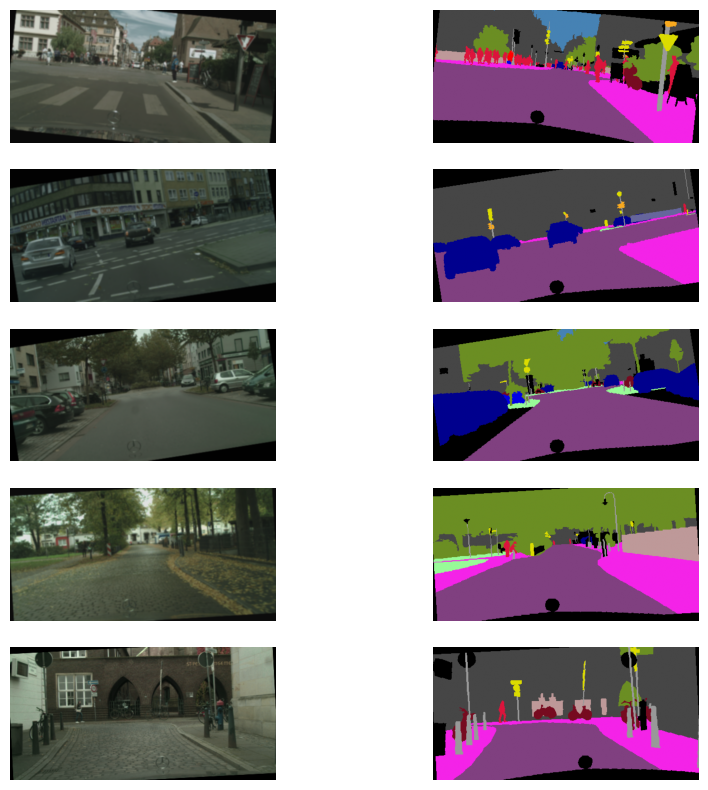

In [11]:
# Testando a funcao de exibicao
dataset_show(train_dataset, n=5, cmap=cmap)

Criar dataloaders

In [12]:
# Criando datalaoders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=True)

In [13]:
# Imprimindo informacoes relevantes dos dataloaders
train_features_batch, train_labels_batch = next(iter(train_dataloader))
val_features_batch, val_labels_batch = next(iter(val_dataloader))
print(f"O pacote de imagens para treino possui tamanho: {train_features_batch.size()}, e o tamanho do pacote da mescaras para treino possui tamanho: {train_labels_batch.size()}")
print(f"O pacote de imagens para validacao possui tamanho: {val_features_batch.size()}, e o tamanho do pacote da mescaras para validacao possui tamanho: {val_labels_batch.size()}")

O pacote de imagens para treino possui tamanho: torch.Size([64, 3, 256, 512]), e o tamanho do pacote da mescaras para treino possui tamanho: torch.Size([64, 256, 512])
O pacote de imagens para validacao possui tamanho: torch.Size([64, 3, 256, 512]), e o tamanho do pacote da mescaras para validacao possui tamanho: torch.Size([64, 256, 512])


## Criar Modelo 

In [14]:
model = lkm.LinkNet(in_channels=3, out_channels=NUM_CLASSES).to(device)
summary(model, input_size=(BATCH_SIZE, 3, IM_HEIGHT, IM_WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
LinkNet                                  [64, 20, 256, 512]        --
├─Sequential: 1-1                        [64, 64, 64, 128]         --
│    └─Conv2d: 2-1                       [64, 64, 128, 256]        9,472
│    └─BatchNorm2d: 2-2                  [64, 64, 128, 256]        128
│    └─ReLU: 2-3                         [64, 64, 128, 256]        --
│    └─MaxPool2d: 2-4                    [64, 64, 64, 128]         --
├─LinkNetEncoderBlock: 1-2               [64, 64, 32, 64]          --
│    └─Sequential: 2-5                   [64, 64, 32, 64]          --
│    │    └─Conv2d: 3-1                  [64, 64, 32, 64]          4,160
│    │    └─BatchNorm2d: 3-2             [64, 64, 32, 64]          128
│    └─Sequential: 2-6                   [64, 64, 32, 64]          --
│    │    └─Conv2d: 3-3                  [64, 64, 32, 64]          36,928
│    │    └─BatchNorm2d: 3-4             [64, 64, 32, 64]          128
│ 

In [15]:
# Testar Modelo com uma imagem do dataset
test_input = train_dataset[0][0].unsqueeze(0).to(device) # Adiciona uma dimensão de batch e move para o dispositivo
test_output = model(test_input)
print(f"Tamanho da entrada: {test_input.shape}\n"
      f"Tamanho da saida: {test_output.shape}")

Tamanho da entrada: torch.Size([1, 3, 256, 512])
Tamanho da saida: torch.Size([1, 20, 256, 512])


In [16]:
# testar softmax e argmax
test_output_softmax = torch.softmax(test_output, dim=1).argmax(dim=1)
print(f"O tamanho do output apos softmax e argmax eh: {test_output_softmax.shape}")
test_output_softmax

O tamanho do output apos softmax e argmax eh: torch.Size([1, 256, 512])


tensor([[[14,  6, 11,  ...,  7, 11, 19],
         [10,  7, 19,  ..., 15,  2,  0],
         [ 9, 10, 15,  ...,  7,  1, 11],
         ...,
         [13,  6,  1,  ...,  9,  9, 16],
         [14,  6, 14,  ...,  9, 14, 19],
         [ 5, 15,  6,  ..., 16, 13, 16]]], device='cuda:0')

## Treinar Modelo E MOSTRAR RESULTADOS

In [17]:
# Treinar o modelo
if SCRIPT_MODE != "TEST":
    fit_model = tr.TrainLinkNet(model=model, device=device, epochs=5)
    fit_model(train_dataloader, val_dataloader)

EPOCH 1/5


  0%|          | 0/47 [00:01<?, ?it/s]

train_loss: 3.0842 | train_iIoU: 0.0504 | val_loss: 2.9375 | val_iIoU: 0.0863

EPOCH 2/5


  0%|          | 0/47 [00:00<?, ?it/s]

train_loss: 2.7450 | train_iIoU: 0.2005 | val_loss: 2.5605 | val_iIoU: 0.3222

EPOCH 3/5


  0%|          | 0/47 [00:00<?, ?it/s]

train_loss: 2.3336 | train_iIoU: 0.3930 | val_loss: 2.1650 | val_iIoU: 0.4724

EPOCH 4/5


  0%|          | 0/47 [00:00<?, ?it/s]

train_loss: 2.0556 | train_iIoU: 0.4930 | val_loss: 1.9892 | val_iIoU: 0.5276

EPOCH 5/5


  0%|          | 0/47 [00:00<?, ?it/s]

train_loss: 1.9112 | train_iIoU: 0.5324 | val_loss: 1.9305 | val_iIoU: 0.5417

Treino do modelo foi finalizado!
O modelo com melhor iIoU foi registrado no Epoch 4.
Esse modelo foi salvo no caminho /home/jose-vitor/Documents/pytorch_projects/linknet/linknet-studynotes/saved_models


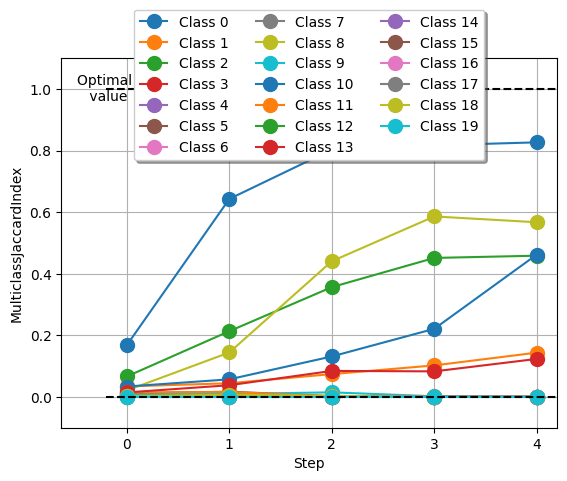

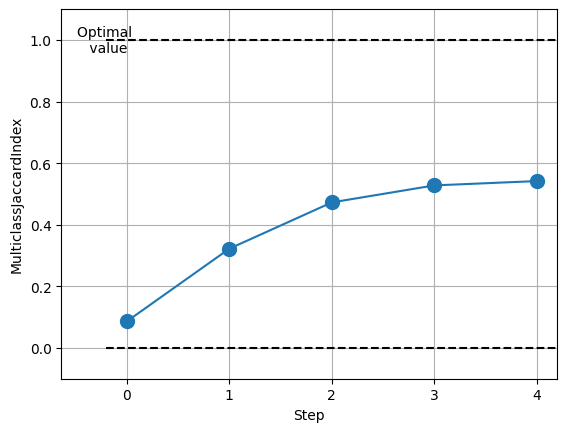

In [19]:
if SCRIPT_MODE != "TEST":
    fig1_, ax1_ = fit_model.iIoU_metric.plot(fit_model.results['val_IoU'])
    fig2_, ax2_ = fit_model.iIoU_metric.plot(fit_model.results['val_iIoU'])

## TESTAR MODELO SALVO

In [20]:
if SCRIPT_MODE != "TRAIN":

    # Criando novo modelo para carregar o salvo
    loaded_model = lkm.LinkNet(in_channels=3, out_channels=NUM_CLASSES).to(device)

    # Carregando apenas os parametros (state_dict()), pois isso flexibiliza o modelo e evita erros de incompatibilidade com parametros e caminhos do modelo original
    # OBS: torch.load() carrega o modelo inteiro, nao apenas os parametros
    MODEL_PATH = Path.cwd() / Path("saved_models")
    MODEL_NAME = "best_model.pth"
    SAVED_MODEL_PATH = MODEL_PATH / MODEL_NAME
    loaded_model.load_state_dict(torch.load(f=SAVED_MODEL_PATH))

    # Teste do modelo
    test = ts.TestLinkNet(loaded_model, device=device)
    test(test_dataloader)

Realizando Teste do Modelo:


  0%|          | 0/24 [00:00<?, ?it/s]

test_loss: nan | test_iIoU: nan


In [21]:
torch.cuda.empty_cache()